In [1]:
import numpy as np
import pandas as pd
import os
print(os.listdir("../predict_future_sales/input/"))
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_importance
import gc

['sales_train.csv', 'Untitled.ipynb', 'shops.csv', 'test.csv', 'item_categories.csv', 'items.csv', 'sample_submission.csv']


In [2]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

In [3]:
pd.get_option("display.max_columns")

#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 120)
#現在の最大表示行数の出力
pd.get_option("display.max_rows")

#最大表示行数の指定（ここでは50行を指定）
pd.set_option('display.max_rows', 300)

In [4]:
DATA_FOLDER = '../predict_future_sales/input'

transactions = pd.read_csv('input/sales_train.csv')
items = pd.read_csv('input/items.csv')
item_categories = pd.read_csv('input/item_categories.csv')
shops = pd.read_csv(os.path.join(DATA_FOLDER,'shops.csv'))


In [5]:
test = pd.read_csv(os.path.join(DATA_FOLDER,'test.csv'))

In [6]:
transactions.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


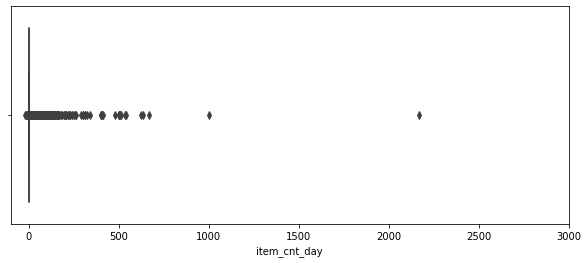

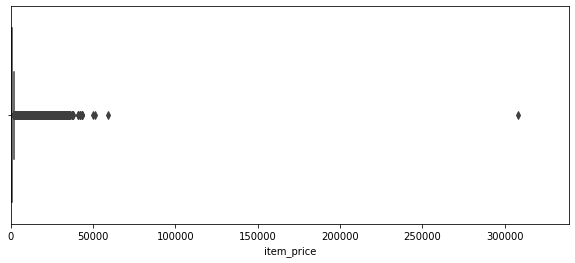

In [7]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=transactions.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(transactions.item_price.min(), transactions.item_price.max()*1.1)
sns.boxplot(x=transactions.item_price)

In [8]:
transactions = transactions[transactions.item_cnt_day < 1001]
transactions  = transactions[transactions.item_price < 100000]

In [9]:
items.head(5)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [10]:
item_categories.head(5)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [11]:
shops.head(10)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [12]:
shops['city_name'] = shops['shop_name'].map(lambda x:x.split(' ')[0])
shops['city_name'].value_counts()

Москва              13
Тюмень               3
РостовНаДону         3
Воронеж              3
Якутск               2
Казань               2
Самара               2
Уфа                  2
Н.Новгород           2
!Якутск              2
Жуковский            2
СПб                  2
Новосибирск          2
Красноярск           2
Коломна              1
Балашиха             1
Чехов                1
Интернет-магазин     1
Курск                1
Выездная             1
Волжский             1
Томск                1
Сергиев              1
Мытищи               1
Вологда              1
Химки                1
Адыгея               1
Сургут               1
Омск                 1
Ярославль            1
Цифровой             1
Калуга               1
Name: city_name, dtype: int64

In [13]:
shops.loc[shops['city_name'] == '!Якутск', 'city_name'] = 'Якутск'
shops.city_name.value_counts()

Москва              13
Якутск               4
Воронеж              3
РостовНаДону         3
Тюмень               3
Уфа                  2
СПб                  2
Самара               2
Н.Новгород           2
Красноярск           2
Жуковский            2
Казань               2
Новосибирск          2
Балашиха             1
Интернет-магазин     1
Коломна              1
Чехов                1
Курск                1
Томск                1
Выездная             1
Волжский             1
Сергиев              1
Мытищи               1
Вологда              1
Химки                1
Адыгея               1
Сургут               1
Омск                 1
Ярославль            1
Цифровой             1
Калуга               1
Name: city_name, dtype: int64

In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [15]:
item_categories['split'] = item_categories['item_category_name'].str.split(' - ')
item_categories['type'] = item_categories['split'].map(lambda x:x[0].strip())
item_categories['subtype'] = item_categories['split'].map(lambda x:x[1].strip() if len(x) > 1 else x[0].strip())
item_categories['type'] = le.fit_transform(item_categories['type'])
item_categories['subtype'] = le.fit_transform(item_categories['subtype'])

item_categories = item_categories[['type','subtype','item_category_id']]

In [16]:
shops['city_name'] = le.fit_transform(shops['city_name'])

encoding = shops.groupby('city_name').size()
encoding = encoding / len(shops)
shops['city_frequency'] = shops.city_name.map(encoding)
shops.city_frequency.describe()

# encoding = test.groupby('item_id').size()
# encoding = encoding/len(test)
# test['item_freq'] = test.item_id.map(encoding)

count    60.000000
mean      0.072778
std       0.077628
min       0.016667
25%       0.016667
50%       0.033333
75%       0.066667
max       0.216667
Name: city_frequency, dtype: float64

In [17]:
transactions = pd.merge(transactions, items, on='item_id', how='left')
transactions = transactions.drop('item_name',axis=1)
transactions.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.00,1.0,37
1,03.01.2013,0,25,2552,899.00,1.0,58
2,05.01.2013,0,25,2552,899.00,-1.0,58
3,06.01.2013,0,25,2554,1709.05,1.0,58
4,15.01.2013,0,25,2555,1099.00,1.0,56


In [18]:
transactions = pd.merge(transactions, shops, on='shop_id', how='left')
transactions.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,shop_name,city_name,city_frequency
0,02.01.2013,0,59,22154,999.00,1.0,37,"Ярославль ТЦ ""Альтаир""",30,0.016667
1,03.01.2013,0,25,2552,899.00,1.0,58,"Москва ТРК ""Атриум""",13,0.216667
2,05.01.2013,0,25,2552,899.00,-1.0,58,"Москва ТРК ""Атриум""",13,0.216667
3,06.01.2013,0,25,2554,1709.05,1.0,58,"Москва ТРК ""Атриум""",13,0.216667
4,15.01.2013,0,25,2555,1099.00,1.0,56,"Москва ТРК ""Атриум""",13,0.216667


In [19]:
transactions["city_cat"] = transactions["city_name"].astype(str) + "_" + transactions["item_category_id"].astype(str)

transactions["city_cat"] = le.fit_transform(transactions["city_cat"])

In [20]:
transactions.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,shop_name,city_name,city_frequency,city_cat
0,02.01.2013,0,59,22154,999.00,1.0,37,"Ярославль ТЦ ""Альтаир""",30,0.016667,1367
1,03.01.2013,0,25,2552,899.00,1.0,58,"Москва ТРК ""Атриум""",13,0.216667,286
2,05.01.2013,0,25,2552,899.00,-1.0,58,"Москва ТРК ""Атриум""",13,0.216667,286
3,06.01.2013,0,25,2554,1709.05,1.0,58,"Москва ТРК ""Атриум""",13,0.216667,286
4,15.01.2013,0,25,2555,1099.00,1.0,56,"Москва ТРК ""Атриум""",13,0.216667,284
5,10.01.2013,0,25,2564,349.00,1.0,59,"Москва ТРК ""Атриум""",13,0.216667,287
6,02.01.2013,0,25,2565,549.00,1.0,56,"Москва ТРК ""Атриум""",13,0.216667,284
7,04.01.2013,0,25,2572,239.00,1.0,55,"Москва ТРК ""Атриум""",13,0.216667,283
8,11.01.2013,0,25,2572,299.00,1.0,55,"Москва ТРК ""Атриум""",13,0.216667,283
9,03.01.2013,0,25,2573,299.00,3.0,55,"Москва ТРК ""Атриум""",13,0.216667,283


In [21]:
from itertools import product
index_col = ['shop_id','item_id','date_block_num']

In [22]:
grid = []
for block_num in transactions['date_block_num'].unique():
    cur_shops = transactions.loc[transactions['date_block_num'] == block_num, 'shop_id'].unique()
    #This shows all shops in three countries working in each month
    cur_items = transactions.loc[transactions['date_block_num']==block_num,'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops,cur_items,[block_num]])),dtype='int32'))
grid = pd.DataFrame(np.vstack(grid),columns=index_col,dtype=np.int32)
grid.head(15)

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0
5,59,2565,0
6,59,2572,0
7,59,2573,0
8,59,2574,0
9,59,2593,0


## Make statistical features

In [23]:
mean_transactions = transactions.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day':'sum','item_price':np.mean}).reset_index()

mean_transactions.head(5)

,date_block_num,shop_id,item_id,item_cnt_day,item_price
0,0,0,32,6.0,221.0
1,0,0,33,3.0,347.0
2,0,0,35,1.0,247.0
3,0,0,43,1.0,221.0
4,0,0,51,2.0,128.5


In [24]:
mean_transactions.columns = ['date_block_num','shop_id','item_id','item_cnt_month','item_price']

In [25]:
mean_transactions.item_cnt_month.describe()

count    1.609123e+06
mean     2.265853e+00
std      8.466196e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.644000e+03
Name: item_cnt_month, dtype: float64

In [26]:
mean_transactions.item_cnt_month = mean_transactions.item_cnt_month.clip(0,20)
mean_transactions.item_cnt_month.describe()

count    1.609123e+06
mean     2.022807e+00
std      2.577964e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.000000e+01
Name: item_cnt_month, dtype: float64

In [27]:
mean_transactions = pd.merge(grid, mean_transactions, on=['date_block_num','shop_id','item_id'],how='left').fillna(0)
mean_transactions.head(10)

,shop_id,item_id,date_block_num,item_cnt_month,item_price
0,59,22154,0,1.0,999.0
1,59,2552,0,0.0,0.0
2,59,2554,0,0.0,0.0
3,59,2555,0,0.0,0.0
4,59,2564,0,0.0,0.0
5,59,2565,0,0.0,0.0
6,59,2572,0,0.0,0.0
7,59,2573,0,0.0,0.0
8,59,2574,0,2.0,399.0
9,59,2593,0,0.0,0.0


In [28]:
mean_transactions = pd.merge(mean_transactions, items, on='item_id',how='left')
mean_transactions.head(10)

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_name,item_category_id
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59
5,59,2565,0,0.0,0.0,DEEP PURPLE Stormbringer (фирм.),56
6,59,2572,0,0.0,0.0,DEFTONES Koi No Yokan,55
7,59,2573,0,0.0,0.0,DEL REY LANA Born To Die,55
8,59,2574,0,2.0,399.0,DEL REY LANA Born To Die The Paradise Editio...,55
9,59,2593,0,0.0,0.0,DEPECHE MODE Music For The Masses,55


In [29]:
shops.drop('shop_name',axis=1,inplace=True)
shops['city_name'].value_counts()

13    13
29     4
24     3
4      3
18     3
15     2
19     2
8      2
16     2
20     2
6      2
25     2
11     2
10     1
5      1
7      1
3      1
2      1
1      1
9      1
30     1
12     1
14     1
17     1
21     1
22     1
23     1
26     1
27     1
28     1
0      1
Name: city_name, dtype: int64

In [30]:
mean_transactions = pd.merge(mean_transactions, shops, on=['shop_id'], how='left')

In [31]:
mean_transactions = pd.merge(mean_transactions, item_categories, on = ['item_category_id'], how='left')

In [32]:
city_cat_df = transactions[['item_category_id','city_name','city_cat']]

In [33]:
city_cat_df = city_cat_df.drop_duplicates()
city_cat_df.head(5)

,item_category_id,city_name,city_cat
0,37,30,1367
1,58,13,286
4,56,13,284
5,59,13,287
7,55,13,283


In [34]:
mean_transactions = pd.merge(mean_transactions, city_cat_df, on=['item_category_id','city_name'], how='left')
mean_transactions.head(5)

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_name,item_category_id,city_name,city_frequency,type,subtype,city_cat
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,30,0.016667,11,1,1367.0
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,30,0.016667,13,29,1382.0
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,30,0.016667,13,29,1382.0
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,30,0.016667,13,5,1380.0
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,30,0.016667,13,42,1383.0


In [35]:
mean_transactions.head(5)

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_name,item_category_id,city_name,city_frequency,type,subtype,city_cat
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,30,0.016667,11,1,1367.0
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,30,0.016667,13,29,1382.0
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,30,0.016667,13,29,1382.0
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,30,0.016667,13,5,1380.0
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,30,0.016667,13,42,1383.0


In [36]:
test['date_block_num'] = 34
test  = pd.merge(test, items, on=['item_id'], how='left')
test = pd.merge(test, shops, on= ['shop_id'], how='left')
test = pd.merge(test, item_categories, on=['item_category_id'], how='left')
test = pd.merge(test, city_cat_df, on=['item_category_id','city_name'], how='left')

In [37]:
del shops, items, item_categories
gc.collect()

2500

In [38]:
test.head(5)

,ID,shop_id,item_id,date_block_num,item_name,item_category_id,city_name,city_frequency,type,subtype,city_cat
0,0,5,5037,34,"NHL 15 [PS3, русские субтитры]",19,3,0.016667,5,12,1412.0
1,1,5,5320,34,ONE DIRECTION Made In The A.M.,55,3,0.016667,13,4,1440.0
2,2,5,5233,34,"Need for Speed Rivals (Essentials) [PS3, русск...",19,3,0.016667,5,12,1412.0
3,3,5,5232,34,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,3,0.016667,5,18,1417.0
4,4,5,5268,34,"Need for Speed [PS4, русская версия]",20,3,0.016667,5,13,1414.0


In [39]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [40]:
transactions['sales'] = transactions['item_cnt_day'] * transactions['item_price']

In [41]:
mean_transactions['product_sales'] = mean_transactions['item_cnt_month'] * mean_transactions['item_price']

In [42]:
mean_transactions.describe()

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_category_id,city_name,city_frequency,type,subtype,city_cat,product_sales
count,1.091380e+07,1.091380e+07,1.091380e+07,1.091380e+07,1.091380e+07,1.091380e+07,1.091380e+07,1.091380e+07,1.091380e+07,1.091380e+07,1.009505e+07,1.091380e+07
mean,3.118720e+01,1.130929e+04,1.497336e+01,2.982411e-01,1.165793e+02,4.491718e+01,1.530064e+01,7.123482e-02,1.107077e+01,1.977707e+01,7.901500e+02,2.776941e+02
std,1.734959e+01,6.209982e+03,9.495635e+00,1.222376e+00,6.518422e+02,1.510617e+01,8.015696e+00,7.756555e-02,2.847759e+00,2.033361e+01,5.160088e+02,3.047254e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.666667e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.600000e+01,5.976000e+03,7.000000e+00,0.000000e+00,0.000000e+00,3.700000e+01,1.000000e+01,1.666667e-02,1.100000e+01,4.000000e+00,2.830000e+02,0.000000e+00
50%,3.000000e+01,1.139100e+04,1.400000e+01,0.000000e+00,0.000000e+00,4.000000e+01,1.300000e+01,3.333333e-02,1.100000e+01,6.000000e+00,7.150000e+02,0.000000e+00
75%,4.600000e+01,1.660500e+04,2.300000e+01,0.000000e+00,0.000000e+00,5.500000e+01,2.200000e+01,6.666667e-02,1.300000e+01,3.400000e+01,1.245000e+03,0.000000e+00
max,5.900000e+01,2.216900e+04,3.300000e+01,2.000000e+01,5.099900e+04,8.300000e+01,3.000000e+01,2.166667e-01,1.900000e+01,6.600000e+01,1.807000e+03,5.998000e+05


In [43]:
lower = np.percentile(mean_transactions.item_price,95)
mean_transactions.item_price = mean_transactions.item_price.clip(0,lower)


lower = np.percentile(mean_transactions.product_sales,95)
mean_transactions.product_sales = mean_transactions.item_price.clip(0,lower)

## I will make the similar dataframe about statistical features, but this time, these are lag features

In [44]:
item_mean = transactions.groupby(['item_id','date_block_num']).mean().reset_index()\
                        [['item_id','item_price','item_cnt_day','date_block_num','sales']]
item_mean.columns = ['item_id','item_price_per_item','item_cnt_day_per_item','date_block_num','sales_per_item']



item_std =transactions.groupby(['item_id','date_block_num']).std().reset_index()\
                        [['item_id','item_cnt_day','date_block_num','sales']]
item_std.columns = ['item_id','cnt_day_std_per_item','date_block_num','sales_std_per_item']

In [45]:
mean_transactions = pd.merge(mean_transactions, item_mean, on=['date_block_num','item_id'],how='left')
mean_transactions = pd.merge(mean_transactions, item_std, on=['date_block_num','item_id'],how='left')
del item_mean
del item_std
gc.collect()


mean_transactions.head(10)

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_name,item_category_id,city_name,city_frequency,type,subtype,city_cat,product_sales,item_price_per_item,item_cnt_day_per_item,sales_per_item,cnt_day_std_per_item,sales_std_per_item
0,59,22154,0,1.0,599.0,ЯВЛЕНИЕ 2012 (BD),37,30,0.016667,11,1,1367.0,599.0,999.000000,1.000000,999.000000,0.000000,0.000000
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,30,0.016667,13,29,1382.0,0.0,899.000000,0.000000,0.000000,1.414214,1271.377993
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,30,0.016667,13,29,1382.0,0.0,1709.050000,1.000000,1709.050000,NaN,NaN
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,30,0.016667,13,5,1380.0,0.0,1098.850000,1.000000,1098.850000,0.000000,0.212132
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,30,0.016667,13,42,1383.0,0.0,327.600000,1.000000,327.600000,0.000000,47.851855
5,59,2565,0,0.0,0.0,DEEP PURPLE Stormbringer (фирм.),56,30,0.016667,13,5,1380.0,0.0,549.000000,1.000000,549.000000,0.000000,0.000000
6,59,2572,0,0.0,0.0,DEFTONES Koi No Yokan,55,30,0.016667,13,4,1379.0,0.0,284.333333,1.000000,284.333333,0.000000,36.275044
7,59,2573,0,0.0,0.0,DEL REY LANA Born To Die,55,30,0.016667,13,4,1379.0,0.0,299.000000,1.142857,341.714286,0.534522,159.822223
8,59,2574,0,2.0,399.0,DEL REY LANA Born To Die The Paradise Editio...,55,30,0.016667,13,4,1379.0,399.0,392.986538,1.144231,450.534615,0.379531,155.777822
9,59,2593,0,0.0,0.0,DEPECHE MODE Music For The Masses,55,30,0.016667,13,4,1379.0,0.0,254.200000,1.000000,254.200000,0.000000,55.454486


In [46]:
mean_transactions = downcast_dtypes(mean_transactions)

gc.collect()

20

In [47]:
shop_mean_df = transactions.groupby(['date_block_num','shop_id']).mean().reset_index()\
                                 [['shop_id','date_block_num','item_cnt_day','sales']]
shop_mean_df.columns = ['shop_id','date_block_num','item_cnt_day_per_shop','sales_per_shop']
mean_transactions = pd.merge(mean_transactions,shop_mean_df, on=['date_block_num','shop_id'],how='left')

shop_std_df =  transactions.groupby(['date_block_num','shop_id']).std().reset_index()\
                                 [['shop_id','date_block_num','item_cnt_day']]
shop_std_df.columns = ['shop_id','date_block_num','cnt_day_std_shop']
mean_transactions = pd.merge(mean_transactions,shop_std_df, on=['date_block_num','shop_id'],how='left')


del shop_mean_df
del shop_std_df
gc.collect()

0

In [48]:
mean_transactions.head(10)

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_name,item_category_id,city_name,city_frequency,type,subtype,city_cat,product_sales,item_price_per_item,item_cnt_day_per_item,sales_per_item,cnt_day_std_per_item,sales_std_per_item,item_cnt_day_per_shop,sales_per_shop,cnt_day_std_shop
0,59,22154,0,1.0,599.0,ЯВЛЕНИЕ 2012 (BD),37,30,0.016667,11,1,1367.0,599.0,999.000000,1.000000,999.000000,0.000000,0.000000,1.092041,884.369789,0.4467
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,30,0.016667,13,29,1382.0,0.0,899.000000,0.000000,0.000000,1.414214,1271.378052,1.092041,884.369789,0.4467
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,30,0.016667,13,29,1382.0,0.0,1709.050049,1.000000,1709.050049,NaN,NaN,1.092041,884.369789,0.4467
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,30,0.016667,13,5,1380.0,0.0,1098.849976,1.000000,1098.849976,0.000000,0.212132,1.092041,884.369789,0.4467
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,30,0.016667,13,42,1383.0,0.0,327.600006,1.000000,327.600006,0.000000,47.851856,1.092041,884.369789,0.4467
5,59,2565,0,0.0,0.0,DEEP PURPLE Stormbringer (фирм.),56,30,0.016667,13,5,1380.0,0.0,549.000000,1.000000,549.000000,0.000000,0.000000,1.092041,884.369789,0.4467
6,59,2572,0,0.0,0.0,DEFTONES Koi No Yokan,55,30,0.016667,13,4,1379.0,0.0,284.333344,1.000000,284.333344,0.000000,36.275043,1.092041,884.369789,0.4467
7,59,2573,0,0.0,0.0,DEL REY LANA Born To Die,55,30,0.016667,13,4,1379.0,0.0,299.000000,1.142857,341.714294,0.534522,159.822220,1.092041,884.369789,0.4467
8,59,2574,0,2.0,399.0,DEL REY LANA Born To Die The Paradise Editio...,55,30,0.016667,13,4,1379.0,399.0,392.986542,1.144231,450.534607,0.379531,155.777817,1.092041,884.369789,0.4467
9,59,2593,0,0.0,0.0,DEPECHE MODE Music For The Masses,55,30,0.016667,13,4,1379.0,0.0,254.199997,1.000000,254.199997,0.000000,55.454487,1.092041,884.369789,0.4467


In [49]:
category_mean_df = transactions.groupby(['date_block_num','item_category_id']).mean().reset_index()[['item_category_id','date_block_num','item_cnt_day','sales']]
category_mean_df.columns = ['item_category_id','date_block_num','item_cnt_day_per_category','sales_per_category']
mean_transactions = pd.merge(mean_transactions, category_mean_df, on=['date_block_num','item_category_id'],how='left')

In [50]:
category_std_df = transactions.groupby(['date_block_num','item_category_id']).std().reset_index()[['item_category_id','date_block_num','item_cnt_day']]
category_std_df.columns = ['item_category_id','date_block_num','cnt_day_std_per_category']
mean_transactions = pd.merge(mean_transactions, category_std_df, on=['date_block_num','item_category_id'],how='left')

In [51]:
shop_cat_df = transactions.groupby(['date_block_num', 'item_category_id', 'shop_id']).mean().reset_index()\
                          [['date_block_num', 'item_category_id', 'shop_id','item_cnt_day']]
shop_cat_df.columns = ['date_block_num','item_category_id','shop_id','cnt_day_shop_cat']
mean_transactions = pd.merge(mean_transactions, shop_cat_df, on=['date_block_num', 'item_category_id','shop_id'], how='left')

In [52]:
del category_mean_df
del category_std_df
del shop_cat_df
gc.collect()

60

In [53]:
mean_transactions = downcast_dtypes(mean_transactions)
mean_transactions.head(10)

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_name,item_category_id,city_name,city_frequency,type,subtype,city_cat,product_sales,item_price_per_item,item_cnt_day_per_item,sales_per_item,cnt_day_std_per_item,sales_std_per_item,item_cnt_day_per_shop,sales_per_shop,cnt_day_std_shop,item_cnt_day_per_category,sales_per_category,cnt_day_std_per_category,cnt_day_shop_cat
0,59,22154,0,1.0,599.0,ЯВЛЕНИЕ 2012 (BD),37,30,0.016667,11,1,1367.0,599.0,999.000000,1.000000,999.000000,0.000000,0.000000,1.092041,884.369812,0.4467,1.053414,491.797668,0.385709,1.016949
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,30,0.016667,13,29,1382.0,0.0,899.000000,0.000000,0.000000,1.414214,1271.378052,1.092041,884.369812,0.4467,0.969595,1371.483154,0.265064,NaN
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,30,0.016667,13,29,1382.0,0.0,1709.050049,1.000000,1709.050049,NaN,NaN,1.092041,884.369812,0.4467,0.969595,1371.483154,0.265064,NaN
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,30,0.016667,13,5,1380.0,0.0,1098.849976,1.000000,1098.849976,0.000000,0.212132,1.092041,884.369812,0.4467,1.007519,876.650024,0.086547,1.000000
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,30,0.016667,13,42,1383.0,0.0,327.600006,1.000000,327.600006,0.000000,47.851856,1.092041,884.369812,0.4467,0.990113,433.212769,0.202288,1.000000
5,59,2565,0,0.0,0.0,DEEP PURPLE Stormbringer (фирм.),56,30,0.016667,13,5,1380.0,0.0,549.000000,1.000000,549.000000,0.000000,0.000000,1.092041,884.369812,0.4467,1.007519,876.650024,0.086547,1.000000
6,59,2572,0,0.0,0.0,DEFTONES Koi No Yokan,55,30,0.016667,13,4,1379.0,0.0,284.333344,1.000000,284.333344,0.000000,36.275043,1.092041,884.369812,0.4467,1.025878,273.485382,0.193638,1.024242
7,59,2573,0,0.0,0.0,DEL REY LANA Born To Die,55,30,0.016667,13,4,1379.0,0.0,299.000000,1.142857,341.714294,0.534522,159.822220,1.092041,884.369812,0.4467,1.025878,273.485382,0.193638,1.024242
8,59,2574,0,2.0,399.0,DEL REY LANA Born To Die The Paradise Editio...,55,30,0.016667,13,4,1379.0,399.0,392.986542,1.144231,450.534607,0.379531,155.777817,1.092041,884.369812,0.4467,1.025878,273.485382,0.193638,1.024242
9,59,2593,0,0.0,0.0,DEPECHE MODE Music For The Masses,55,30,0.016667,13,4,1379.0,0.0,254.199997,1.000000,254.199997,0.000000,55.454487,1.092041,884.369812,0.4467,1.025878,273.485382,0.193638,1.024242


In [54]:
mean_transactions.head(5)

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_name,item_category_id,city_name,city_frequency,type,subtype,city_cat,product_sales,item_price_per_item,item_cnt_day_per_item,sales_per_item,cnt_day_std_per_item,sales_std_per_item,item_cnt_day_per_shop,sales_per_shop,cnt_day_std_shop,item_cnt_day_per_category,sales_per_category,cnt_day_std_per_category,cnt_day_shop_cat
0,59,22154,0,1.0,599.0,ЯВЛЕНИЕ 2012 (BD),37,30,0.016667,11,1,1367.0,599.0,999.000000,1.0,999.000000,0.000000,0.000000,1.092041,884.369812,0.4467,1.053414,491.797668,0.385709,1.016949
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,30,0.016667,13,29,1382.0,0.0,899.000000,0.0,0.000000,1.414214,1271.378052,1.092041,884.369812,0.4467,0.969595,1371.483154,0.265064,NaN
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,30,0.016667,13,29,1382.0,0.0,1709.050049,1.0,1709.050049,NaN,NaN,1.092041,884.369812,0.4467,0.969595,1371.483154,0.265064,NaN
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,30,0.016667,13,5,1380.0,0.0,1098.849976,1.0,1098.849976,0.000000,0.212132,1.092041,884.369812,0.4467,1.007519,876.650024,0.086547,1.000000
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,30,0.016667,13,42,1383.0,0.0,327.600006,1.0,327.600006,0.000000,47.851856,1.092041,884.369812,0.4467,0.990113,433.212769,0.202288,1.000000


In [55]:
city_df = mean_transactions.groupby(['date_block_num','city_name']).mean().reset_index()\
                [['date_block_num','city_name','item_cnt_month']]
city_df.columns = ['date_block_num','city_name','item_cnt_day_city']
mean_transactions = pd.merge(mean_transactions, city_df, on=['date_block_num','city_name'], how='left')

del city_df
gc.collect()

0

In [56]:
cat_city_df = mean_transactions.groupby(['date_block_num','city_name','item_category_id']).mean().reset_index()\
                [['date_block_num','city_name','item_category_id','item_cnt_month']]
cat_city_df.columns = ['date_block_num','city_name','item_category_id','item_cnt_day_city_cat']
mean_transactions = pd.merge(mean_transactions, cat_city_df, on=['date_block_num','city_name','item_category_id'], how='left')

del cat_city_df
gc.collect()

20

In [57]:
mean_transactions.head(5)

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_name,item_category_id,city_name,city_frequency,type,subtype,city_cat,product_sales,item_price_per_item,item_cnt_day_per_item,sales_per_item,cnt_day_std_per_item,sales_std_per_item,item_cnt_day_per_shop,sales_per_shop,cnt_day_std_shop,item_cnt_day_per_category,sales_per_category,cnt_day_std_per_category,cnt_day_shop_cat,item_cnt_day_city,item_cnt_day_city_cat
0,59,22154,0,1.0,599.0,ЯВЛЕНИЕ 2012 (BD),37,30,0.016667,11,1,1367.0,599.0,999.000000,1.0,999.000000,0.000000,0.000000,1.092041,884.369812,0.4467,1.053414,491.797668,0.385709,1.016949,0.246827,0.088496
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,30,0.016667,13,29,1382.0,0.0,899.000000,0.0,0.000000,1.414214,1271.378052,1.092041,884.369812,0.4467,0.969595,1371.483154,0.265064,NaN,0.246827,0.000000
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,30,0.016667,13,29,1382.0,0.0,1709.050049,1.0,1709.050049,NaN,NaN,1.092041,884.369812,0.4467,0.969595,1371.483154,0.265064,NaN,0.246827,0.000000
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,30,0.016667,13,5,1380.0,0.0,1098.849976,1.0,1098.849976,0.000000,0.212132,1.092041,884.369812,0.4467,1.007519,876.650024,0.086547,1.000000,0.246827,0.008333
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,30,0.016667,13,42,1383.0,0.0,327.600006,1.0,327.600006,0.000000,47.851856,1.092041,884.369812,0.4467,0.990113,433.212769,0.202288,1.000000,0.246827,0.011976


## Create Lag features 

In [58]:
#These are variables which are presented as lag features
lag_variables = list(mean_transactions.columns[12:]) + ['item_cnt_month']
lag_cnt_variables = []
lag_price_variables = []
for feat in lag_variables:
    if 'std' in feat:
        lag_price_variables.append(feat)
    elif 'price' in feat:
        lag_price_variables.append(feat)
    elif 'sales'in feat:
        lag_cnt_variables.append(feat)
    elif 'cnt' in feat:
        lag_cnt_variables.append(feat)
    

        
lags= [1,2,3,4]
from tqdm import tqdm_notebook
for lag in tqdm_notebook(lags):
    sales_new_df = mean_transactions.copy()
    sales_new_df.date_block_num += lag
    sales_new_df = sales_new_df[['date_block_num','shop_id','item_id'] + lag_cnt_variables]
    sales_new_df.columns = ['date_block_num','shop_id','item_id'] + [lag_fest+'_lag_'+ str(lag) for lag_fest in lag_cnt_variables]
    mean_transactions = pd.merge(mean_transactions, sales_new_df, on = ['date_block_num','shop_id','item_id'],how='left')
    del sales_new_df

In [59]:
lag_price_variables

['item_price_per_item',
 'cnt_day_std_per_item',
 'sales_std_per_item',
 'cnt_day_std_shop',
 'cnt_day_std_per_category']

In [60]:
lag_cnt_variables

['product_sales',
 'item_cnt_day_per_item',
 'sales_per_item',
 'item_cnt_day_per_shop',
 'sales_per_shop',
 'item_cnt_day_per_category',
 'sales_per_category',
 'cnt_day_shop_cat',
 'item_cnt_day_city',
 'item_cnt_day_city_cat',
 'item_cnt_month']

In [61]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id', col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col + '_lag_' + str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on = ['date_block_num','shop_id','item_id'] , how='left')
    return df

In [62]:
type_df = mean_transactions.groupby(['date_block_num','type']).mean().reset_index()\
                [['date_block_num','type','item_cnt_month']]
type_df.columns = ['date_block_num','type','item_cnt_month_per_type']
mean_transactions = pd.merge(mean_transactions, type_df, on=['date_block_num','type'],how='left')

In [63]:
subtype_df = mean_transactions.groupby(['date_block_num','subtype']).mean().reset_index()\
                [['date_block_num','subtype','item_cnt_month']]
subtype_df.columns = ['date_block_num','subtype','item_cnt_month_subtype']
mean_transactions = pd.merge(mean_transactions, subtype_df, on=['date_block_num','subtype'],how='left')



In [64]:
subtype_city_df = mean_transactions.groupby(['date_block_num','subtype','city_name']).mean().reset_index()\
                [['date_block_num','subtype','city_name','item_cnt_month']]
subtype_city_df.columns = ['date_block_num','subtype','city_name','item_cnt_month_subtype_city']
mean_transactions = pd.merge(mean_transactions, subtype_city_df, on=['date_block_num','city_name','subtype'],how='left')


subtype_shop_df = mean_transactions.groupby(['date_block_num','subtype','shop_id']).mean().reset_index()\
                                    [['date_block_num','subtype','shop_id','item_cnt_month']]
subtype_shop_df.columns = ['date_block_num','subtype','shop_id','item_cnt_month_subtype_shop']
mean_transactions = pd.merge(mean_transactions, subtype_shop_df, on=['date_block_num','shop_id','subtype'],how='left')




lag_price_variables.extend(['item_cnt_month_per_type','item_cnt_month_subtype',\
                                                 'item_cnt_month_subtype_city', 'item_cnt_month_subtype_shop'])
lag_variables = lag_cnt_variables + lag_price_variables
del subtype_city_df
del subtype_shop_df
del type_df
del subtype_df
gc.collect()

0

In [65]:
delta_lags = [1,2]
from tqdm import tqdm_notebook
for lag in tqdm_notebook(delta_lags):
    sales_new_df = mean_transactions.copy()
    sales_new_df.date_block_num += lag
    sales_new_df = sales_new_df[['date_block_num','shop_id','item_id'] + lag_price_variables]
    sales_new_df.columns = ['date_block_num','shop_id','item_id'] + [lag_fest+'_lag_'+ str(lag) for lag_fest in lag_price_variables]
    mean_transactions = pd.merge(mean_transactions, sales_new_df, on = ['date_block_num','shop_id','item_id'],how='left')
    del sales_new_df

In [66]:
mean_transactions.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month', 'item_price',
       'item_name', 'item_category_id', 'city_name', 'city_frequency', 'type',
       'subtype', 'city_cat', 'product_sales', 'item_price_per_item',
       'item_cnt_day_per_item', 'sales_per_item', 'cnt_day_std_per_item',
       'sales_std_per_item', 'item_cnt_day_per_shop', 'sales_per_shop',
       'cnt_day_std_shop', 'item_cnt_day_per_category', 'sales_per_category',
       'cnt_day_std_per_category', 'cnt_day_shop_cat', 'item_cnt_day_city',
       'item_cnt_day_city_cat', 'product_sales_lag_1',
       'item_cnt_day_per_item_lag_1', 'sales_per_item_lag_1',
       'item_cnt_day_per_shop_lag_1', 'sales_per_shop_lag_1',
       'item_cnt_day_per_category_lag_1', 'sales_per_category_lag_1',
       'cnt_day_shop_cat_lag_1', 'item_cnt_day_city_lag_1',
       'item_cnt_day_city_cat_lag_1', 'item_cnt_month_lag_1',
       'product_sales_lag_2', 'item_cnt_day_per_item_lag_2',
       'sales_per_item_lag_2', 'item_cnt

In [67]:
beta_mean_feat = ['item_cnt_day_per_item','item_cnt_day_per_shop','item_cnt_day_per_category']
sales_feat = ['sales_per_item','sales_per_shop','sales_per_category','product_sales']

for feat in beta_mean_feat:
    mean_transactions[feat + '_mean_3'] = np.mean(mean_transactions[[feat + '_lag_1', feat + "_lag_2", feat + '_lag_3']]).fillna(0)
    mean_transactions[feat + '_mean_2'] = np.mean(mean_transactions[[feat + '_lag_1', feat + "_lag_2"]]).fillna(0)
    
for feat in sales_feat:
    mean_ = np.mean(mean_transactions[[feat + "_lag_1",feat + "_lag_2"]])
    mean_transactions[feat + "_trend"] = (mean_transactions[feat  +"_lag_1"] - mean_)/mean_
    mean_transactions[feat + "_trend"] = mean_transactions[feat + "_trend"].fillna(0)

In [68]:
item_shop_first_sale_df = mean_transactions.groupby(['item_id','shop_id']).agg({'date_block_num':'min'}).reset_index()[['item_id','shop_id','date_block_num']]
item_shop_first_sale_df.columns = ['item_id','shop_id','item_shop_first_date_block_num']

item_first_sale_df = mean_transactions.groupby(['item_id']).agg({'date_block_num':'min'}).\
                                    reset_index()[['item_id','date_block_num']]
item_first_sale_df.columns = ['item_id','item_first_date_block_num']

In [69]:

mean_transactions = pd.merge(mean_transactions, item_shop_first_sale_df, on=['item_id','shop_id'], how='left')
mean_transactions = pd.merge(mean_transactions, item_first_sale_df, on=['item_id'],how='left')

mean_transactions['time_since_item_shop_first'] = mean_transactions['date_block_num']\
                                                                                            - mean_transactions['item_shop_first_date_block_num']
mean_transactions['time_since_item_first'] = mean_transactions['date_block_num']\
                                                                                            - mean_transactions['item_first_date_block_num']

In [70]:
mean_transactions.drop('item_shop_first_date_block_num' ,axis=1,inplace=True)
mean_transactions.drop('item_first_date_block_num' ,axis=1,inplace=True)

In [71]:
mean_transactions = mean_transactions[mean_transactions['date_block_num'] > 11]

In [72]:
for feat in mean_transactions.columns:
    if 'cnt' in feat:
        mean_transactions[feat] = mean_transactions[feat].fillna(0)
    elif 'price' in feat:
        mean_transactions[feat] = mean_transactions[feat].fillna(mean_transactions[feat].median())

In [73]:
lag_variables.remove('item_cnt_month')
lag_variables

['product_sales',
 'item_cnt_day_per_item',
 'sales_per_item',
 'item_cnt_day_per_shop',
 'sales_per_shop',
 'item_cnt_day_per_category',
 'sales_per_category',
 'cnt_day_shop_cat',
 'item_cnt_day_city',
 'item_cnt_day_city_cat',
 'item_price_per_item',
 'cnt_day_std_per_item',
 'sales_std_per_item',
 'cnt_day_std_shop',
 'cnt_day_std_per_category',
 'item_cnt_month_per_type',
 'item_cnt_month_subtype',
 'item_cnt_month_subtype_city',
 'item_cnt_month_subtype_shop']

In [74]:
cols_to_drop = lag_variables + ['item_price','item_name']
cols_to_drop

['product_sales',
 'item_cnt_day_per_item',
 'sales_per_item',
 'item_cnt_day_per_shop',
 'sales_per_shop',
 'item_cnt_day_per_category',
 'sales_per_category',
 'cnt_day_shop_cat',
 'item_cnt_day_city',
 'item_cnt_day_city_cat',
 'item_price_per_item',
 'cnt_day_std_per_item',
 'sales_std_per_item',
 'cnt_day_std_shop',
 'cnt_day_std_per_category',
 'item_cnt_month_per_type',
 'item_cnt_month_subtype',
 'item_cnt_month_subtype_city',
 'item_cnt_month_subtype_shop',
 'item_price',
 'item_name']

## Special Features

In [75]:
mean_transactions['month'] = mean_transactions['date_block_num'] % 12

In [76]:
mean_transactions['month'] = mean_transactions['month'].astype(np.int8)
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
mean_transactions['days'] = mean_transactions['month'].map(days).astype(np.int8)

In [77]:
cnt_feats = ['item_cnt_month_lag_1','item_cnt_day_per_item_lag_1','item_cnt_day_per_shop_lag_1','item_cnt_day_per_category_lag_1',\
                        'product_sales_lag_1', "sales_per_item_lag_1",'sales_per_shop_lag_1','sales_per_category_lag_1']



for feat in cnt_feats:
    mean_transactions[feat+'_day'] = mean_transactions[feat] / mean_transactions["days"]

In [78]:
  holiday_dict = {
    0: 6,
    1: 3,
    2: 2,
    3: 8,
    4: 3,
    5: 3,
    6: 2,
    7: 8,
    8: 4,
    9: 8,
    10: 5,
    11: 4,
}
    
mean_transactions['holidays_in_month'] = mean_transactions['month'].map(holiday_dict).astype(np.int8)

In [79]:
cache = {}
mean_transactions['item_shop_last_sale'] = -1
mean_transactions['item_shop_last_sale'] = mean_transactions['item_shop_last_sale'].astype(np.int8)

for row in mean_transactions.itertuples():
    idx = getattr(row, 'Index')
    item_id = getattr(row, 'item_id')
    shop_id = getattr(row, 'shop_id')
    date_block_num = getattr(row, 'date_block_num')
    item_cnt_month = getattr(row, 'item_cnt_month')
    key = str(int(item_id)) + ' ' + str(int(shop_id))
    if key not in cache:
        if item_cnt_month != 0:
            cache[key] = date_block_num
    else:
        last_date_block_num = cache[key]
        mean_transactions.at[idx, 'item_shop_last_sale'] = date_block_num -  last_date_block_num
        cache[key] = date_block_num
        
mean_transactions[['item_id','shop_id', 'item_shop_last_sale']].to_pickle('train_item_shop_last_sale.pkl')

# train_item_shop_last_sale_df = pd.read_pickle('train_item_shop_last_sale.pkl')
# mean_transactions = pd.merge(mean_transactions, train_item_shop_last_sale_df, on=['item_id', 'shop_id'], how='left')
# del train_item_shop_last_sale_df
gc.collect()

0

In [80]:
training = mean_transactions.drop(cols_to_drop,axis=1)

In [81]:
import xgboost as xgb

In [82]:
len(training.columns)

96

In [83]:
training.head(5)

,shop_id,item_id,date_block_num,item_cnt_month,item_category_id,city_name,city_frequency,type,subtype,city_cat,product_sales_lag_1,item_cnt_day_per_item_lag_1,sales_per_item_lag_1,item_cnt_day_per_shop_lag_1,sales_per_shop_lag_1,item_cnt_day_per_category_lag_1,sales_per_category_lag_1,cnt_day_shop_cat_lag_1,item_cnt_day_city_lag_1,item_cnt_day_city_cat_lag_1,item_cnt_month_lag_1,product_sales_lag_2,item_cnt_day_per_item_lag_2,sales_per_item_lag_2,item_cnt_day_per_shop_lag_2,sales_per_shop_lag_2,item_cnt_day_per_category_lag_2,sales_per_category_lag_2,cnt_day_shop_cat_lag_2,item_cnt_day_city_lag_2,item_cnt_day_city_cat_lag_2,item_cnt_month_lag_2,product_sales_lag_3,item_cnt_day_per_item_lag_3,sales_per_item_lag_3,item_cnt_day_per_shop_lag_3,sales_per_shop_lag_3,item_cnt_day_per_category_lag_3,sales_per_category_lag_3,cnt_day_shop_cat_lag_3,item_cnt_day_city_lag_3,item_cnt_day_city_cat_lag_3,item_cnt_month_lag_3,product_sales_lag_4,item_cnt_day_per_item_lag_4,sales_per_item_lag_4,item_cnt_day_per_shop_lag_4,sales_per_shop_lag_4,item_cnt_day_per_category_lag_4,sales_per_category_lag_4,cnt_day_shop_cat_lag_4,item_cnt_day_city_lag_4,item_cnt_day_city_cat_lag_4,item_cnt_month_lag_4,item_price_per_item_lag_1,cnt_day_std_per_item_lag_1,sales_std_per_item_lag_1,cnt_day_std_shop_lag_1,cnt_day_std_per_category_lag_1,item_cnt_month_per_type_lag_1,item_cnt_month_subtype_lag_1,item_cnt_month_subtype_city_lag_1,item_cnt_month_subtype_shop_lag_1,item_price_per_item_lag_2,cnt_day_std_per_item_lag_2,sales_std_per_item_lag_2,cnt_day_std_shop_lag_2,cnt_day_std_per_category_lag_2,item_cnt_month_per_type_lag_2,item_cnt_month_subtype_lag_2,item_cnt_month_subtype_city_lag_2,item_cnt_month_subtype_shop_lag_2,item_cnt_day_per_item_mean_3,item_cnt_day_per_item_mean_2,item_cnt_day_per_shop_mean_3,item_cnt_day_per_shop_mean_2,item_cnt_day_per_category_mean_3,item_cnt_day_per_category_mean_2,sales_per_item_trend,sales_per_shop_trend,sales_per_category_trend,product_sales_trend,time_since_item_shop_first,time_since_item_first,month,days,item_cnt_month_lag_1_day,item_cnt_day_per_item_lag_1_day,item_cnt_day_per_shop_lag_1_day,item_cnt_day_per_category_lag_1_day,product_sales_lag_1_day,sales_per_item_lag_1_day,sales_per_shop_lag_1_day,sales_per_category_lag_1_day,holidays_in_month,item_shop_last_sale
4488710,54,10297,12,4.0,37,26,0.016667,11,1,1109.0,599.0,1.000000,741.560730,1.363205,1325.088135,1.049310,442.938934,1.105368,0.989378,0.585946,3.0,0.0,1.000000,749.000000,1.413036,1116.532471,1.065480,500.228394,1.149573,0.796143,0.589744,0.0,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.0,NaN,0.0,NaN,0.000000,NaN,0.000000,NaN,0.00,0.000000,0.000000,0.0,741.560730,0.000000,42.685207,1.929046,0.299793,0.269904,0.232808,0.585946,0.585946,749.000000,0.000000,0.000000,2.273691,0.367059,0.221425,0.183129,0.589744,0.589744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2,0,31,0.096774,0.032258,0.043974,0.033849,19.322580,23.921314,42.744778,14.288353,6,-1
4488711,54,10296,12,3.0,38,26,0.016667,11,2,1110.0,0.0,1.000000,1599.000000,1.363205,1325.088135,1.018868,1010.793640,0.943925,0.989378,0.551913,0.0,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.0,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.0,NaN,0.0,NaN,0.000000,NaN,0.000000,NaN,0.00,0.000000,0.000000,0.0,1599.000000,0.000000,0.000000,1.929046,0.259239,0.269904,0.243645,0.551913,0.551913,325.111115,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,31,0.000000,0.032258,0.043974,0.032867,0.000000,51.580647,42.744778,32.606247,6,-1
4488712,54,10298,12,14.0,40,26,0.016667,11,6,1113.0,399.0,1.308511,514.968079,1.363205,1325.088135,1.163135,316.957184,1.296547,0.989378,0.822974,20.0,399.0,2.226191,872.614014,1.413036,1116.532471,1.187626,321.334412,1.390933,0.796143,0.813202,20.0,389.0,2.526316,985.750854,1.337876,941.237061,1.168003,308.036682,1.306716,0.687399,0.706338,7.0,NaN,0.0,NaN

In [84]:
training = downcast_dtypes(training)
test = downcast_dtypes(test)


training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6425094 entries, 4488710 to 10913803
Data columns (total 96 columns):
shop_id                                int32
item_id                                int32
date_block_num                         int32
item_cnt_month                         float32
item_category_id                       int32
city_name                              int32
city_frequency                         float32
type                                   int32
subtype                                int32
city_cat                               float32
product_sales_lag_1                    float32
item_cnt_day_per_item_lag_1            float32
sales_per_item_lag_1                   float32
item_cnt_day_per_shop_lag_1            float32
sales_per_shop_lag_1                   float32
item_cnt_day_per_category_lag_1        float32
sales_per_category_lag_1               float32
cnt_day_shop_cat_lag_1                 float32
item_cnt_day_city_lag_1                float32
i

In [85]:
X_train = training[training.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = training[training.date_block_num < 33]['item_cnt_month']
X_valid = training[training.date_block_num == 33].drop(['item_cnt_month'], axis=1)
y_valid = training[training.date_block_num == 33]['item_cnt_month']

In [86]:
xgbtrain = xgb.DMatrix(X_train.values, Y_train.values)
xgbvalid = xgb.DMatrix(X_valid.values, y_valid.values)
evals = [(xgbtrain, 'train'), (xgbvalid, 'eval')]

In [87]:
params = {
          'max_depth':8,
          'subsample':0.8,
          'min_child_weight':300,
          'colsample_bytree':0.8,
          'eta':0.3,'num_round':1000,
          'seed':1,
          'silent':0,
          'eval_metric':'rmse'
         }
bst = xgb.train(params, xgbtrain, num_boost_round=1000,early_stopping_rounds=10, evals=evals, verbose_eval=1)

[17:50:31] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	train-rmse:1.05891	eval-rmse:1.05423
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[1]	train-rmse:0.965854	eval-rmse:0.98401
[2]	train-rmse:0.914622	eval-rmse:0.950158
[3]	train-rmse:0.884966	eval-rmse:0.934076
[4]	train-rmse:0.866469	eval-rmse:0.925974
[5]	train-rmse:0.854934	eval-rmse:0.920597
[6]	train-rmse:0.846761	eval-rmse:0.917969
[7]	train-rmse:0.842252	eval-rmse:0.917226
[8]	train-rmse:0.836309	eval-rmse:0.91385
[9]	train-rmse:0.833314	eval-rmse:0.913555
[10]	train-rmse:0.830347	eval-rmse:0.913814
[11]	train-rmse:0.826226	eval-rmse:0.914386
[12]	train-rmse:0.823339	eval-rmse:0.913436
[13]	train-rmse:0.821232	eval-rmse:0.914144
[14]	train-rmse:0.819479	eval-rmse:0.912919
[15]	tra

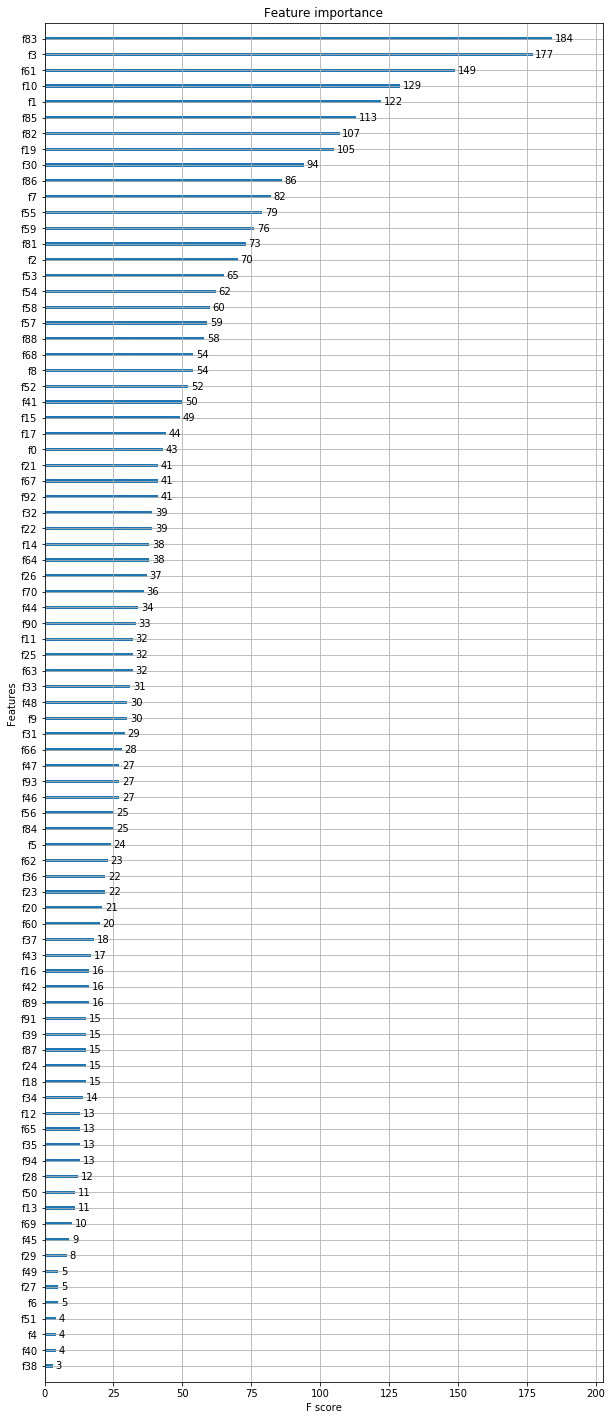

In [88]:
plot_features(bst, (10,25))

### 役に立つ特徴量

In [89]:
cols = list(training.columns)

del cols[cols.index('item_cnt_month')]
[cols[x] for x in [3,83,61,19,85,10]]

['item_category_id',
 'month',
 'item_cnt_month_subtype_shop_lag_1',
 'item_cnt_month_lag_1',
 'item_cnt_month_lag_1_day',
 'item_cnt_day_per_item_lag_1']

### 役に立たない特徴量

In [90]:
cols = list(training.columns)

del cols[cols.index('item_cnt_month')]
[cols[x] for x in [50,4,29,90,49,38,69]]

['item_cnt_day_city_lag_4',
 'city_name',
 'item_cnt_day_city_cat_lag_2',
 'sales_per_item_lag_1_day',
 'cnt_day_shop_cat_lag_4',
 'cnt_day_shop_cat_lag_3',
 'item_cnt_month_subtype_city_lag_2']

In [91]:
xgb_val_predict = xgb.DMatrix(X_valid.values)
val_pred = bst.predict(xgb_val_predict)

pd.Series(val_pred).describe()

count    238172.000000
mean          0.269280
std           0.776709
min          -1.167439
25%           0.024241
50%           0.077126
75%           0.227005
max          22.629709
dtype: float64

In [92]:
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

In [93]:
category_feat_drop = ['days','type','city_name']

In [94]:
#ensembleのためにpickleファイルに保存する
#training.to_pickle('data.pkl')

In [95]:
len(lag_cnt_variables)

11

In [96]:
len(lag_price_variables)

9

In [97]:
for lag in tqdm_notebook(lags):
    sales_new_df = mean_transactions.copy()
    sales_new_df.date_block_num += lag
    sales_new_df = sales_new_df[['date_block_num', 'shop_id','item_id'] + lag_cnt_variables]
    sales_new_df.columns = ['date_block_num','shop_id','item_id'] + [lag_feat + '_lag_'  + str(lag) for lag_feat in lag_cnt_variables]
    test = pd.merge(test, sales_new_df, on=['date_block_num','shop_id','item_id'],how='left')

In [98]:
for lag in tqdm_notebook(delta_lags):
    sales_new_df = mean_transactions.copy()
    sales_new_df.date_block_num += lag
    sales_new_df = sales_new_df[['date_block_num', 'shop_id','item_id'] + lag_price_variables]
    sales_new_df.columns = ['date_block_num','shop_id','item_id'] + [lag_feat + '_lag_'  + str(lag) for lag_feat in lag_price_variables]
    test = pd.merge(test, sales_new_df, on=['date_block_num','shop_id','item_id'],how='left')

In [99]:
test.head(10)

,ID,shop_id,item_id,date_block_num,item_name,item_category_id,city_name,city_frequency,type,subtype,city_cat,product_sales_lag_1,item_cnt_day_per_item_lag_1,sales_per_item_lag_1,item_cnt_day_per_shop_lag_1,sales_per_shop_lag_1,item_cnt_day_per_category_lag_1,sales_per_category_lag_1,cnt_day_shop_cat_lag_1,item_cnt_day_city_lag_1,item_cnt_day_city_cat_lag_1,item_cnt_month_lag_1,product_sales_lag_2,item_cnt_day_per_item_lag_2,sales_per_item_lag_2,item_cnt_day_per_shop_lag_2,sales_per_shop_lag_2,item_cnt_day_per_category_lag_2,sales_per_category_lag_2,cnt_day_shop_cat_lag_2,item_cnt_day_city_lag_2,item_cnt_day_city_cat_lag_2,item_cnt_month_lag_2,product_sales_lag_3,item_cnt_day_per_item_lag_3,sales_per_item_lag_3,item_cnt_day_per_shop_lag_3,sales_per_shop_lag_3,item_cnt_day_per_category_lag_3,sales_per_category_lag_3,cnt_day_shop_cat_lag_3,item_cnt_day_city_lag_3,item_cnt_day_city_cat_lag_3,item_cnt_month_lag_3,product_sales_lag_4,item_cnt_day_per_item_lag_4,sales_per_item_lag_4,item_cnt_day_per_shop_lag_4,sales_per_shop_lag_4,item_cnt_day_per_category_lag_4,sales_per_category_lag_4,cnt_day_shop_cat_lag_4,item_cnt_day_city_lag_4,item_cnt_day_city_cat_lag_4,item_cnt_month_lag_4,item_price_per_item_lag_1,cnt_day_std_per_item_lag_1,sales_std_per_item_lag_1,cnt_day_std_shop_lag_1,cnt_day_std_per_category_lag_1,item_cnt_month_per_type_lag_1,item_cnt_month_subtype_lag_1,item_cnt_month_subtype_city_lag_1,item_cnt_month_subtype_shop_lag_1,item_price_per_item_lag_2,cnt_day_std_per_item_lag_2,sales_std_per_item_lag_2,cnt_day_std_shop_lag_2,cnt_day_std_per_category_lag_2,item_cnt_month_per_type_lag_2,item_cnt_month_subtype_lag_2,item_cnt_month_subtype_city_lag_2,item_cnt_month_subtype_shop_lag_2
0,0,5,5037,34,"NHL 15 [PS3, русские субтитры]",19,3,0.016667,5,12,1412.0,0.0,1.000000,1499.000000,1.090155,1140.12439,1.041791,1785.249023,1.013514,0.190098,0.513699,0.0,599.0,1.428571,1258.038940,1.148265,1231.808594,1.273688,1863.874756,1.195652,0.2059,0.696203,1.0,599.0,1.190000,1036.971558,1.080134,969.072205,1.126207,1239.744751,1.062016,0.245106,0.830303,3.0,599.0,1.102041,1643.990967,1.070194,891.38446,1.036868,1480.884033,1.015873,0.179786,0.387879,1.0,1499.00000,0.000000,0.000000,0.449938,0.304898,0.494105,0.337299,0.447059,0.447059,941.385193,1.657746,1266.470825,0.877853,1.332492,0.611331,0.521406,0.647727,0.647727
1,1,5,5320,34,ONE DIRECTION Made In The A.M.,55,3,0.016667,13,4,1440.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,5,5233,34,"Need for Speed Rivals (Essentials) [PS3, русск...",19,3,0.016667,5,12,1412.0,599.0,1.024390,1228.243896,1.090155,1140.12439,1.041791,1785.249023,1.013514,0.190098,0.513699,1.0,599.0,1.250000,861.546875,1.148265,1231.808594,1.273688,1863.874756,1.195652,0.2059,0.696203,3.0,599.0,1.181102,820.688721,1.080134,969.072205,1.126207,1239.744751,1.062016,0.245106,0.830303,1.0,0.0,1.027778,1232.291626,1.070194,891.38446,1.036868,1480.884033,1.015873,0.179786,0.387879,0.0,1199.00000,0.156174,187.252335,0.449938,0.304898,0.494105,0.337299,0.447059,0.447059,711.705750,0.617213,397.915894,0.877853,1.332492,0.611331,0.521406,0.647727,0.647727
3,3,5,5232,34,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,3,0.016667,5,18,1417.0,0.0,0.933333,1110.500000,1.090155,1140.12439,1.055582,1942.550293,1.000000,0.190098,0.374150,0.0,0.0,1.043478,729.543457,1.148265,1231.808594,1.261420,1754.693115,1.125000,0.2059,0.443662,0.0,599.0,1.203704,764.544983,1.080134,969.072205,1.093142,1243.218628,1.085714,0.245106,0.487179,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1190.43335,0.365148,438.708344,0.449938,0.338878,0.494105,0.331764,0.349112,0.349112,703.489136,0.206185,250.106216,0.877853,1.194525,0.611331,0.539307,0.411043,0.411043
4,4,5,5268,34,"Need for Speed [PS4, русская версия]",20,3,0.016667,5,13,1414.0,NaN,NaN,N

In [100]:
for feat in beta_mean_feat:
    test[feat + '_mean_3'] = np.mean(test[[feat + '_lag_1', feat + "_lag_2", feat + '_lag_3']]).fillna(0)
    test[feat + '_mean_2'] = np.mean(test[[feat + '_lag_1', feat + "_lag_2"]]).fillna(0)
    
for feat in sales_feat:
    mean_ = np.mean(test[[feat + "_lag_1",feat + "_lag_2"]])
    test[feat + "_trend"] = (test[feat  +"_lag_1"] - mean_)/mean_
    test[feat + "_trend"] = test[feat + "_trend"].fillna(0)

In [101]:
test = pd.merge(test, item_shop_first_sale_df, on=['item_id','shop_id'], how='left')
test = pd.merge(test, item_first_sale_df, on=['item_id'],how='left')
test['item_shop_first_date_block_num'] = test['item_shop_first_date_block_num'].fillna(34)
test['item_first_date_block_num'] = test['item_first_date_block_num'].fillna(34)
test['time_since_item_shop_first'] = test['date_block_num'] - test['item_shop_first_date_block_num']

In [102]:
test['time_since_item_first'] = test['date_block_num'] - test['item_first_date_block_num']

test.drop(['item_shop_first_date_block_num','item_first_date_block_num'], axis=1,inplace=True)

del item_shop_first_sale_df,item_first_sale_df
gc.collect()

85

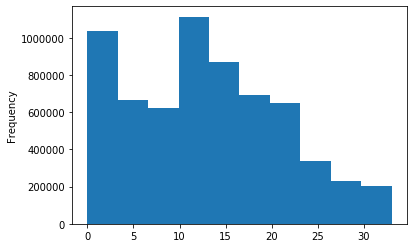

In [103]:
mean_transactions.time_since_item_first.plot.hist()

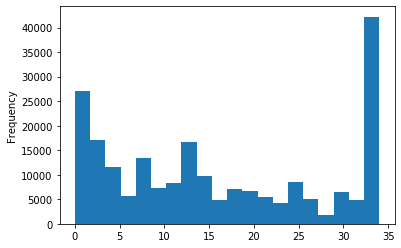

In [104]:
test.time_since_item_first.plot.hist(bins=20)

In [105]:
test.time_since_item_first.describe()

count    214200.000000
mean         16.177451
std          12.099472
min           0.000000
25%           5.000000
50%          13.000000
75%          28.000000
max          34.000000
Name: time_since_item_first, dtype: float64

In [106]:
test = test.drop(['ID','item_name'], axis=1)

In [107]:
for feat in test.columns:
    if 'cnt' in feat:
        test[feat] = test[feat].fillna(0)
    elif 'price' in feat:
        test[feat] = test[feat].fillna(test[feat].median())

In [108]:
test['month'] = test['date_block_num'] % 12
test['month'] = test['month'].astype(np.int8)
test['days'] = 30

for feat in cnt_feats:
    test[feat+'_day'] = test[feat] / test["days"]

In [109]:
test['holidays_in_month'] = test['month'].map(holiday_dict).astype(np.int8)

In [110]:
test['item_shop_last_sale'] = -1
test['item_shop_last_sale'] = test['item_shop_last_sale'].astype(np.int8)
for row in test.itertuples():
    idx = getattr(row, 'Index')
    item_id = getattr(row, 'item_id')
    shop_id = getattr(row, 'shop_id')
    date_block_num = getattr(row, 'date_block_num')
    key = str(item_id) + ' ' + str(shop_id)
    if key  in cache:
        last_date_block_num = cache[key]
        test.at[idx, 'item_shop_last_sale'] = date_block_num - last_date_block_num
        

test[['item_id','shop_id', 'item_shop_last_sale']].to_pickle('test_item_shop_last_sale.pkl')

# test_item_shop_last_sale = pd.read_pickle('test_item_shop_last_sale.pkl')
# test = pd.merge(test, test_item_shop_last_sale, on=['item_id','shop_id'], how='left')

In [111]:
#test.to_pickle('test_data.pkl')

In [112]:
xgbpredict = xgb.DMatrix(test.values)

In [113]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 95 columns):
shop_id                                214200 non-null int32
item_id                                214200 non-null int32
date_block_num                         214200 non-null int32
item_category_id                       214200 non-null int32
city_name                              214200 non-null int32
city_frequency                         214200 non-null float32
type                                   214200 non-null int32
subtype                                214200 non-null int32
city_cat                               190911 non-null float32
product_sales_lag_1                    167622 non-null float32
item_cnt_day_per_item_lag_1            214200 non-null float32
sales_per_item_lag_1                   167622 non-null float32
item_cnt_day_per_shop_lag_1            214200 non-null float32
sales_per_shop_lag_1                   167622 non-null float32
item_cnt_day_per_cate

In [114]:
training.columns[-20:]

Index(['item_cnt_day_per_category_mean_3', 'item_cnt_day_per_category_mean_2',
       'sales_per_item_trend', 'sales_per_shop_trend',
       'sales_per_category_trend', 'product_sales_trend',
       'time_since_item_shop_first', 'time_since_item_first', 'month', 'days',
       'item_cnt_month_lag_1_day', 'item_cnt_day_per_item_lag_1_day',
       'item_cnt_day_per_shop_lag_1_day',
       'item_cnt_day_per_category_lag_1_day', 'product_sales_lag_1_day',
       'sales_per_item_lag_1_day', 'sales_per_shop_lag_1_day',
       'sales_per_category_lag_1_day', 'holidays_in_month',
       'item_shop_last_sale'],
      dtype='object')

In [115]:
diff = list( set(training.columns) -set(test.columns))
diff

['item_cnt_month']

In [116]:
pred = bst.predict(xgbpredict)

In [117]:
# X_test_lr = test.drop(category_feat, axis=1)

# for feat in X_test_lr.columns:
#     X_test_lr[feat] = X_test_lr[feat].fillna(X_test_lr[feat].median())

# X_test_lr["date_block_num"] = X_test_lr.date_block_num.astype(str)
# X_test_lr.to_csv('lr_test.csv',index=False)
# X_test_lr["date_block_num"] = pd.get_dummies(X_test_lr.date_block_num,sparse=False)

In [118]:
# X_test_lr = scaler.fit_transform(X_test_lr)
# pred_lr = lr.predict(X_test_lr)
# pred_lr = pred_lr.clip(0,20)

In [119]:
pd.Series(pred).describe()

count    214200.000000
mean          0.296563
std           0.827154
min          -1.054411
25%           0.024019
50%           0.094335
75%           0.253669
max          21.397905
dtype: float64

In [120]:
# pd.Series(pred_lr).describe()

In [121]:
pred = pred.clip(0,20)

## 標準偏差を付け加えた時と線形回帰とxbgboostの結果。スコアは0.94と1.10

In [122]:
pd.Series(pred).describe()

count    214200.000000
mean          0.298840
std           0.825177
min           0.000000
25%           0.024019
50%           0.094335
75%           0.253669
max          20.000000
dtype: float64

In [123]:
sub_df = pd.DataFrame({'ID':test.index,'item_cnt_month':pred})

In [124]:
#  sub_lr_df = pd.DataFrame({'ID':test.index,'item_cnt_month':pred_lr})

In [125]:
sub_df.head()

,ID,item_cnt_month
0,0,0.475051
1,1,0.393450
2,2,0.979906
3,3,0.479184
4,4,2.625076


In [126]:
sub_df.to_csv('early_stop_xgb_last_sale.csv',index=False)

In [127]:
#sub_lr_df.to_csv('lr_std.csv',index=False)